# NLP Exploratory Data Analysis (EDA)

This notebook explores the required steps required for a Natural Language Processing (NLP) application. This includes:
- Section 1 - Text Cleaning
    - Spelling Correction
- Section 2 - Preprocessing
    - Sentence Segmentation (not applicable in this case) & Tokenization
    - Stop word removal
    - Stemming & Lemmatization
- Section 3 - Feature Engineering
    - Bag-of-Words
    - Ngram-of-Words
    - Embeddings
- Section 4 - Feature Visualization

**Insights:**
- The dataset is quite balanced (57/43)
- Location require extensive preprocessing. One of the approaches might be dropping those below certain count, as it can be considered polluted records.
- There seem to be a considerable amount of tweets with links

In [82]:
import os
import sys
import pandas as pd
import numpy as np
from tqdm import tqdm
import gensim
import gensim.downloader as api
from gensim.models import KeyedVectors

# NLP Preprocessing
import nltk
from nltk.tokenize import TweetTokenizer
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer

# NLP Viz
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

# Feature Extraction
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

# Data Modelling
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, roc_auc_score, recall_score
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.manifold import TSNE
from sklearn.dummy import DummyClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
import xgboost
from xgboost import XGBClassifier
xgboost.config_context(verbosity=0) # Silect XGBoost

# Monitoring progress
from tqdm.notebook import tqdm_notebook
tqdm_notebook.pandas()

nltk.download('stopwords')

config = {
    'test_size': 0.2,
    'CV_splits': 5,
    'seed': 14,
    'n_cores': 16,
    'max_features': 10000,
    'refresh_embedding': False
}

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/miguelcachosoblechero/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# 0. Load dataset and basic counts

In [59]:
# Load dataset
input_path = "../input"
raw_tweets = pd.read_csv(os.path.join(input_path, "train.csv")).drop(['id'], axis=1)
raw_tweets.head()

,keyword,location,text,target
0,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [60]:
(raw_tweets.target.value_counts() / len(raw_tweets)) * 100.0

0    57.034021
1    42.965979
Name: target, dtype: float64

In [61]:
raw_tweets.location.value_counts()

USA                    104
New York                71
United States           50
London                  45
Canada                  29
                      ... 
MontrÌ©al, QuÌ©bec       1
Montreal                 1
ÌÏT: 6.4682,3.18287      1
Live4Heed??              1
Lincoln                  1
Name: location, Length: 3341, dtype: int64

# 2. Text Preprocessing

Convert the text into a tokenized version by and preprocess it, lowercasing all words, removing stop words and performing stemming and lemmatization.
Lastly, I convert each label to a wordcloud

In [62]:
# Use Twitter Tokenizer to tokenize tweets
tokenizer = TweetTokenizer()

# Tokenize raw tweets
raw_tweets['twitterTokens'] = raw_tweets.apply(lambda x: tokenizer.tokenize(x.text.lower()), axis=1)
raw_tweets.head()

,keyword,location,text,target,twitterTokens
0,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1,"[our, deeds, are, the, reason, of, this, #eart..."
1,NaN,NaN,Forest fire near La Ronge Sask. Canada,1,"[forest, fire, near, la, ronge, sask, ., canada]"
2,NaN,NaN,All residents asked to 'shelter in place' are ...,1,"[all, residents, asked, to, ', shelter, in, pl..."
3,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1,"[13,000, people, receive, #wildfires, evacuati..."
4,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1,"[just, got, sent, this, photo, from, ruby, #al..."


In [63]:
# Remove stop words
english_stopwords = set(stopwords.words('english'))
raw_tweets['twitterTokens_noStop'] = raw_tweets.twitterTokens.apply(lambda x: [i for i in x if i not in english_stopwords])

# Perform stemming
ps = PorterStemmer()
raw_tweets['twitterTokens_Stem'] = raw_tweets.twitterTokens_noStop.apply(lambda x: [ps.stem(i) for i in x])

In [64]:
raw_tweets.head()

,keyword,location,text,target,twitterTokens,twitterTokens_noStop,twitterTokens_Stem
0,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1,"[our, deeds, are, the, reason, of, this, #eart...","[deeds, reason, #earthquake, may, allah, forgi...","[deed, reason, #earthquak, may, allah, forgiv,..."
1,NaN,NaN,Forest fire near La Ronge Sask. Canada,1,"[forest, fire, near, la, ronge, sask, ., canada]","[forest, fire, near, la, ronge, sask, ., canada]","[forest, fire, near, la, rong, sask, ., canada]"
2,NaN,NaN,All residents asked to 'shelter in place' are ...,1,"[all, residents, asked, to, ', shelter, in, pl...","[residents, asked, ', shelter, place, ', notif...","[resid, ask, ', shelter, place, ', notifi, off..."
3,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1,"[13,000, people, receive, #wildfires, evacuati...","[13,000, people, receive, #wildfires, evacuati...","[13,000, peopl, receiv, #wildfir, evacu, order..."
4,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1,"[just, got, sent, this, photo, from, ruby, #al...","[got, sent, photo, ruby, #alaska, smoke, #wild...","[got, sent, photo, rubi, #alaska, smoke, #wild..."


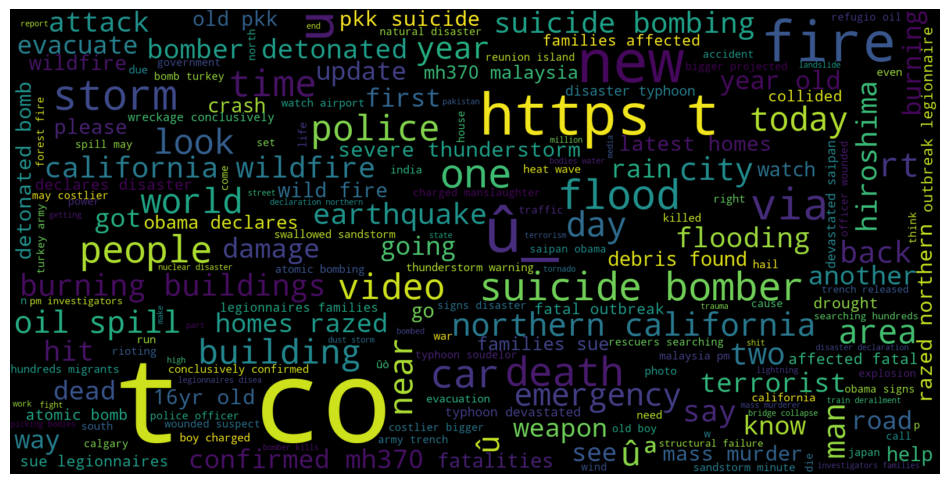

In [65]:
# Extrat the text with real Disaster
disaster_tweets = raw_tweets[raw_tweets.target == 1]
disaster_words = []
for tweet in disaster_tweets.twitterTokens_noStop:
    for word in tweet:
        disaster_words.append(word)
disaster_words = pd.Series(disaster_words).str.cat(sep=' ')

wordcloud = WordCloud(width=1600, height=800,max_font_size=200).generate(disaster_words)
plt.figure(figsize=(12,10))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()


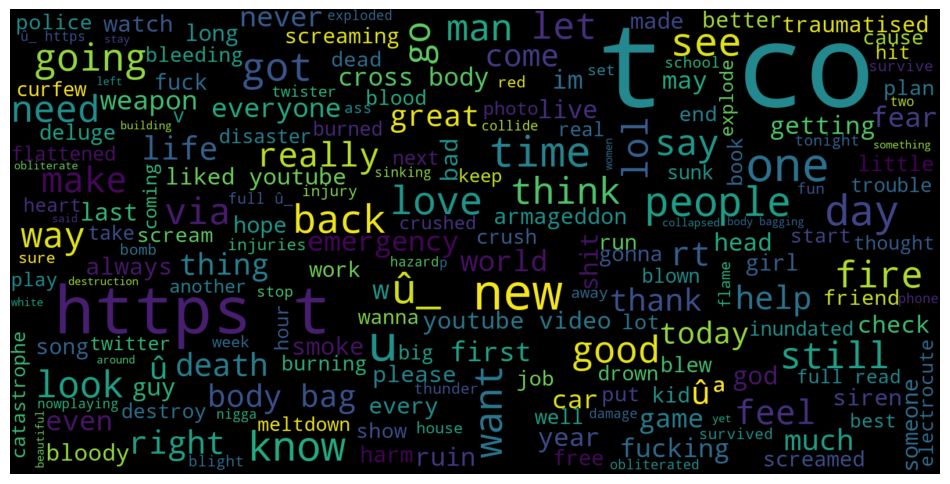

In [66]:
# Extrat the text with no real Disaster
not_disaster_tweets = raw_tweets[raw_tweets.target == 0]
not_disaster_words = []
for tweet in not_disaster_tweets.twitterTokens_noStop:
    for word in tweet:
        not_disaster_words.append(word)
not_disaster_words = pd.Series(not_disaster_words).str.cat(sep=' ')

wordcloud = WordCloud(width=1600, height=800,max_font_size=200).generate(not_disaster_words)
plt.figure(figsize=(12,10))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

# 3. Feature Engineering
In this section, we will explore multiple approaches:
- Bag-of-Words
- Ngram-of-Words
- Word Embeddings + Average across sentence

In [67]:
X = raw_tweets.drop(['target'], axis=1)
y = raw_tweets.target.values

In [32]:
# We start by doing this by hand
def vectorize_tweet(tweet, vocab):
    '''
    This function puts 0 if the word is not present in tokens and count of token if present
    :param tweet: Specific tweet
    :param vocab: Seen vocab
    :return: BoW for this tweet
    '''
    vector=[]
    for w in vocab:
        vector.append(tweet.count(w))
    return vector

def get_vocab(all_tweets):
    '''
    This functions returns a list in which the order remains 
    same and no item repeats
    '''
    # Flatten list
    all_tweets_concat = [word for tweet in all_tweets for word in tweet]
    # Extract unique vocabulary
    seen = set()
    return [x for x in all_tweets_concat if not (x in seen or seen.add(x))]

In [ ]:
# Extract unique vocabulary
vocab = get_vocab(X.twitterTokens_Stem.tolist())

# Vectorize and create a training dataframe for this
X = X.twitterTokens_Stem.progress_apply(vectorize_tweet, vocab=vocab)
X = pd.DataFrame(X.tolist(), columns=vocab)

# This manual process misses some of the functionality that CountVectorizer performs

In [68]:
# CountVectorizer can be used to perform this action in normal text
CountVec = CountVectorizer(stop_words='english', max_features=config['max_features'])
X_bow = CountVec.fit_transform(X.text)

In [69]:
# CountVectorizer can be used to extract NGrams
CountVecNGram = CountVectorizer(stop_words='english', max_features=config['max_features'], ngram_range=(2,2))
X_ngrams = CountVecNGram.fit_transform(X.text)

In [70]:
# TfidfVectorizer can be used to perform this action in normal text
CountVecTFIDF = TfidfVectorizer(stop_words='english', max_features=config['max_features'])
X_tfidf = CountVecTFIDF.fit_transform(X.text)

In [86]:
# Download or load from local
if config['refresh_embedding']:
    # Download Google's pre-trained Word2Vec model
    word2vec = api.load('word2vec-google-news-300')
    # Save the model for future reuse
    word2vec.save_word2vec_format('../Word2Vec/word2vec_300.kv')
else:
    word2vec = KeyedVectors.load_word2vec_format('../Word2Vec/word2vec_300.kv')

In [98]:
# Generate Embeddings
def average_embedding(tweet, word_embeddings, missing_random=False, dimension=300):
    
    # Create target embedding
    final_emb = np.zeros(dimension)
    num_words = len(tweet)

    # For each word in sentence
    for word in tweet:

        # Look for key
        if word in word_embeddings:
            final_emb += word_embeddings[word]

        # If missing...
        else:
            if missing_random:
                final_emb += np.random.rand(dimension)
            else:
                final_emb += np.zeros(dimension)
                
    # Average embeddings
    if num_words == 0:
        return np.zeros(dimension)
    else:
        return final_emb/num_words


# Create embeddings by averaging the sentence
embeddings = X.text.apply(average_embedding, word_embeddings=word2vec, missing_random=False)
X_embeddings = pd.DataFrame(embeddings.tolist())

# 4. Feature Visualization

This section creates visualizations for the extracted features

In [54]:
def plot_projection(X, y):
    # Extract PCA
    proj = TruncatedSVD(random_state=config['seed'])
    X_proj = proj.fit_transform(X)
    X_proj = pd.DataFrame(X_proj, columns=['feat1', 'feat2'])
    X_proj['label'] = y

    # Plot PCA
    plt.figure(figsize=(8,8))
    sns.scatterplot(data=X_proj, x='feat1', y='feat2', hue='label')

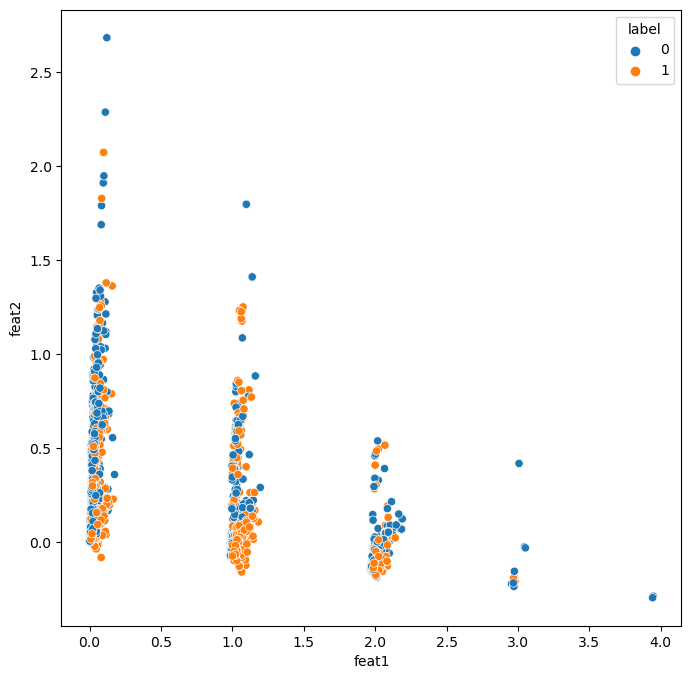

In [55]:
# Bag-of-words
plot_projection(X_bow, y)

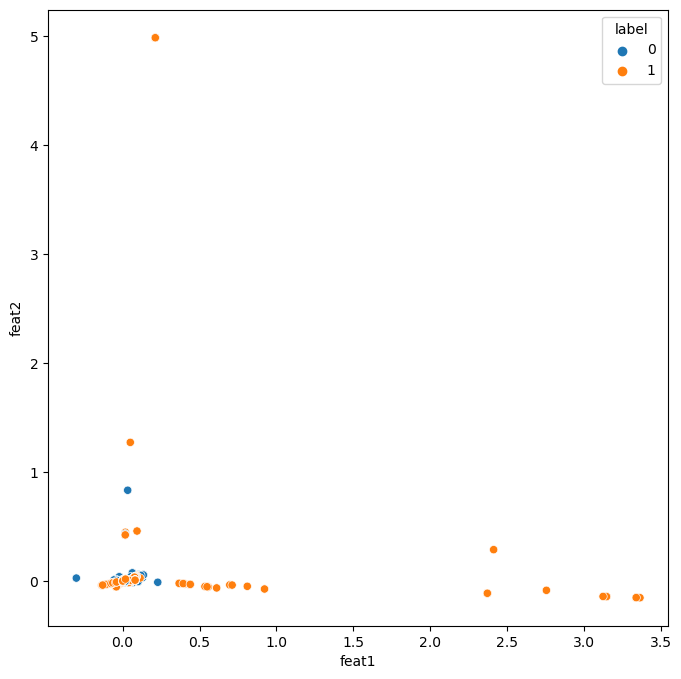

In [56]:
# NGrams
plot_projection(X_ngrams, y)

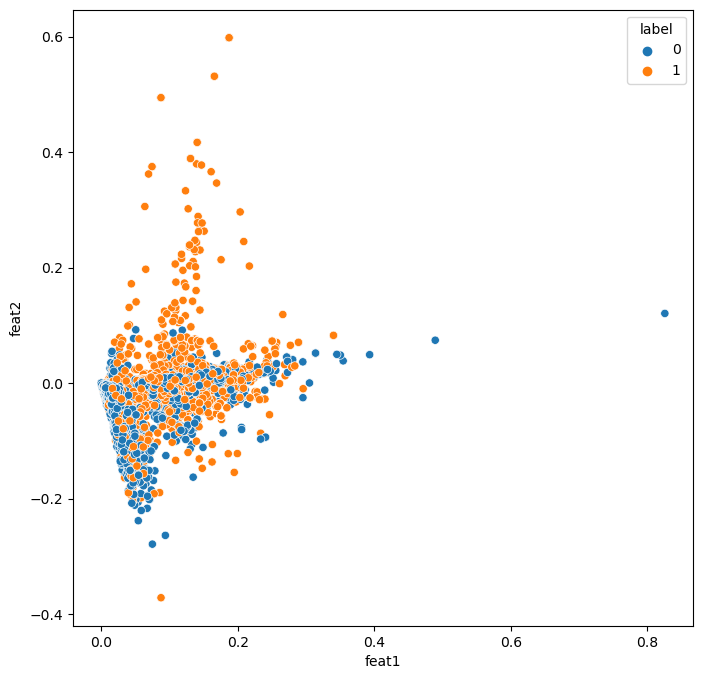

In [57]:
# TF-IDF
plot_projection(X_tfidf, y)

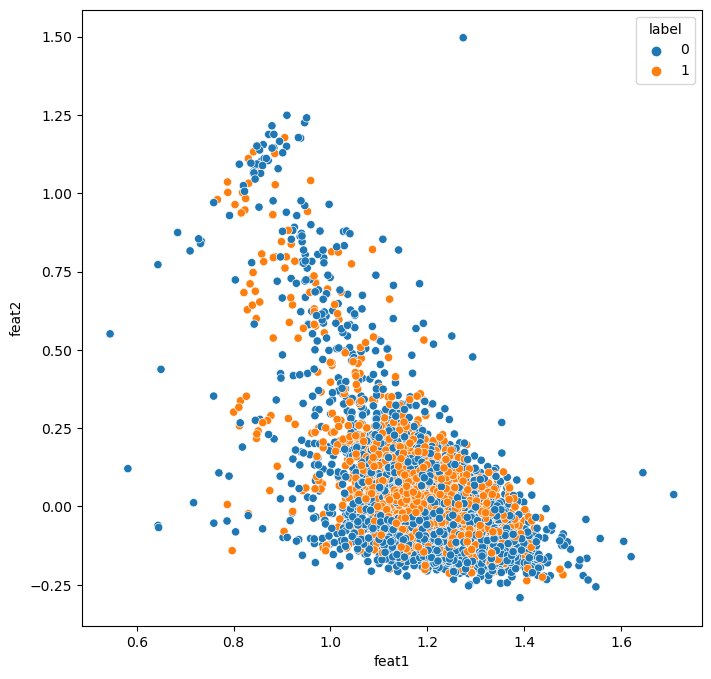

In [99]:
# Embeddings
plot_projection(X_embeddings, y)